<a href="https://colab.research.google.com/github/Akanksha-cell-max/Advanced-Artificial-Intelligence/blob/main/Practical_No_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training complete!


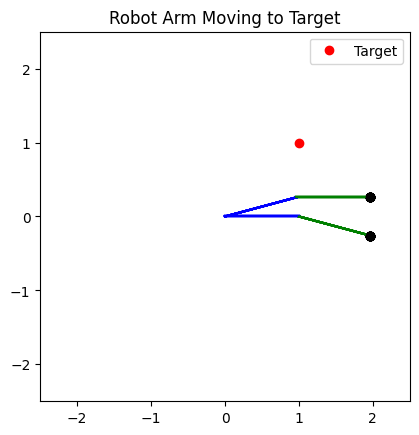

In [2]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Arm parameters
link_length = 1.0  # each arm segment length
angle_increment = 15  # degrees to change per action

# Discretize the angles
angle_space = np.arange(0, 360, angle_increment)

# Actions: (delta_theta1, delta_theta2)
actions = [(-angle_increment, 0), (angle_increment, 0), (0, -angle_increment), (0, angle_increment)]

# Target position
target = np.array([1.0, 1.0])

# Q-table (θ₁ x θ₂ x actions)
q_table = np.zeros((len(angle_space), len(angle_space), len(actions)))

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 0.3
epsilon_decay = 0.995
episodes = 1000

# Helper functions
def get_end_effector(theta1, theta2):
    """Calculate end effector position given two angles."""
    x = link_length * np.cos(np.radians(theta1)) + link_length * np.cos(np.radians(theta1 + theta2))
    y = link_length * np.sin(np.radians(theta1)) + link_length * np.sin(np.radians(theta1 + theta2))
    return np.array([x, y])

def get_joint_positions(theta1, theta2):
    """Get positions of joints for plotting."""
    joint1 = np.array([link_length * np.cos(np.radians(theta1)),
                       link_length * np.sin(np.radians(theta1))])
    end_effector = joint1 + np.array([link_length * np.cos(np.radians(theta1 + theta2)),
                                      link_length * np.sin(np.radians(theta1 + theta2))])
    return np.array([[0, 0], joint1, end_effector])

def get_distance(pos, target):
    """Euclidean distance."""
    return np.linalg.norm(pos - target)

def discretize_angle(angle):
    """Find the closest discrete angle index."""
    return int(round(angle / angle_increment)) % len(angle_space)

# Training loop
for ep in range(episodes):
    theta1 = random.choice(angle_space)
    theta2 = random.choice(angle_space)
    done = False
    step = 0

    while not done and step < 200:
        # Epsilon-greedy policy
        if random.uniform(0,1) < epsilon:
            action_idx = random.randint(0, len(actions)-1)
        else:
            action_idx = np.argmax(q_table[discretize_angle(theta1)][discretize_angle(theta2)])

        delta_theta1, delta_theta2 = actions[action_idx]

        # Apply action
        theta1 = (theta1 + delta_theta1) % 360
        theta2 = (theta2 + delta_theta2) % 360

        # Calculate reward
        effector_pos = get_end_effector(theta1, theta2)
        distance = get_distance(effector_pos, target)
        reward = -distance

        # Update Q-table
        current_q = q_table[discretize_angle(theta1)][discretize_angle(theta2)][action_idx]
        next_max_q = np.max(q_table[discretize_angle(theta1)][discretize_angle(theta2)])

        q_table[discretize_angle(theta1)][discretize_angle(theta2)][action_idx] = \
            current_q + alpha * (reward + gamma * next_max_q - current_q)

        if distance < 0.1:  # Close enough
            done = True

        step += 1

    # Decay epsilon
    epsilon *= epsilon_decay

print("\nTraining complete!")

# Test and visualize
theta1, theta2 = 0, 0
path = [(theta1, theta2)]

fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.plot(target[0], target[1], 'ro', label='Target')

for _ in range(30):
    action_idx = np.argmax(q_table[discretize_angle(theta1)][discretize_angle(theta2)])
    delta_theta1, delta_theta2 = actions[action_idx]
    theta1 = (theta1 + delta_theta1) % 360
    theta2 = (theta2 + delta_theta2) % 360
    path.append((theta1, theta2))
    effector_pos = get_end_effector(theta1, theta2)

    joints = get_joint_positions(theta1, theta2)
    ax.plot([joints[0][0], joints[1][0]], [joints[0][1], joints[1][1]], 'b-')  # Link 1
    ax.plot([joints[1][0], joints[2][0]], [joints[1][1], joints[2][1]], 'g-')  # Link 2
    ax.plot(joints[2][0], joints[2][1], 'ko')  # End Effector

    if get_distance(effector_pos, target) < 0.1:
        break

plt.title("Robot Arm Moving to Target")
plt.legend()
plt.show()
